In [1]:
import torch
from torch import nn

In [2]:
class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super(RNNScratch, self).__init__()
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        # nn.Parameter automatically register a class attribute as a parameter to be tracked by autograd
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state = state

        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

Recall that 
\begin{equation}
    H_t = \varphi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
\end{equation}
and
\begin{equation}
    O_t = H_tW_{hq} + b_q.
\end{equation}
We aim to solve
\begin{equation}
\begin{aligned}
    & \min_{W,b}\frac{1}{T}\sum_{t=1}^{T}l(y_t,O_t(W,b)) \\
    & \text{subject to} \\
    & H_t = \varphi(X_tW_{xh} + H_{t-1}W_{hh} + b_h) \\
    & O_t = H_tW_{hq} + b_q,\quad t=1,...,T.
\end{aligned}
\end{equation}

**Remark**. Hidden state $H_t$ is not model's parameter. It is a temporary variable that holds the data and is updated in the next iteration.


In [3]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 5, 3, 10
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)
print(f'outputs: {outputs}')
print(f'X.shape: {X.shape}')
print(f'state.shape: {state.shape}')
print(f'rnn.W_xh.shape: {rnn.W_xh.shape}')
print(f'rnn.W_hh.shape: {rnn.W_hh.shape}')
print(f'rnn.b_h.shape: {rnn.b_h.shape}')

outputs: [tensor([[-0.0020, -0.0279, -0.0127],
        [-0.0020, -0.0279, -0.0127]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0122],
        [-0.0017, -0.0276, -0.0122]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_fn=<TanhBackward0>), tensor([[-0.0017, -0.0276, -0.0123],
        [-0.0017, -0.0276, -0.0123]], grad_f

### Dimensionality of input
Write $T$ = num_steps, $B$ = batch_size and $p$ = num_inputs. <br> 
Every time we have $X_1$, $X_2$, ..., $X_T$, where $X_i$ is a $B$ by $p$ matrix. 

In [4]:
X

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

## RNN-based Character-Level Language Models

In [5]:
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l
from torch import nn
from torch.nn import functional as F

In [6]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""

    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.init_params()
        self.lr = lr

    def init_params(self):
        # weights in the output layer
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])    

### Data preparation

In [7]:
device_name = 'cuda:0'
batch_size, num_hiddens, num_steps = 1024, 32, 10
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
print(f'data.vocab.token_to_idx: {data.vocab.token_to_idx}')

data.vocab.token_to_idx: {' ': 0, '<unk>': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


In [9]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset.

    Defined in :numref:`sec_text-sequence`"""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
        """Defined in :numref:`sec_text-sequence`"""
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        """Defined in :numref:`sec_text-sequence`"""
        return list(text)

    def build(self, raw_text, vocab=None):
        """Defined in :numref:`sec_text-sequence`"""
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        """Defined in :numref:`sec_language-model`"""
        super(d2l.TimeMachine, self).__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = d2l.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)

1. Tokenization: ```build```
2. Perform text scanning using a fixed length: array = d2l.tensor([corpus[i:i+num_steps+1]  for i in range(len(corpus)-num_steps)]. For example, when num_steps=10, array has shape torch.Size([173418, 11])
3. Construct X and Y: self.X, self.Y = array[:,:-1], array[:,1:]`

In [10]:
data.X[0], data.Y[0]

(tensor([21,  9,  6,  0, 21, 10, 14,  6,  0, 14]),
 tensor([ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2]))

### Dimensionality of input
1. Raw $X$ is a bacth_size by num_steps matrix, where $X_{ij}=0,1,...,27$.
2. The embedding inputs ```embs = self.one_hot(X)``` has shape: num_steps by batch_size by vocab_size. <br>
Question: Why we do ```F.one_hot(X.T)```?

### Embedding
An embedding is a representation of features in a lower-dimensional space. For example, in natural language processing tasks, words or characters can be embedded into continuous vectors using techniques like Word2Vec and GloVe. These embeddings capture semantic or syntactic information, enabling the model to understand the relationships between words or characters.

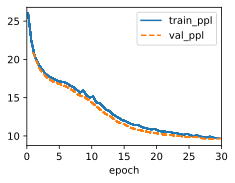

In [11]:
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=num_hiddens)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
plt.show()

## Training

In [12]:
class Trainer(d2l.HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]
    

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [d2l.to(a, self.gpus[0]) for a in batch]
        return batch
    

    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

### Loss function in **seq2seq** classification

```
def loss(self, Y_hat, Y, averaged=True):
    """Defined in :numref:`sec_softmax_concise`"""
    Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = d2l.reshape(Y, (-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')
```

Let $T$ be the num_steps. We aim to minimize <br>
\begin{equation}
    \min_{W,b}\frac{1}{T}\sum_{t=1}^{T}CE(\mathbf{y}_t,\textcolor{blue}{\text{softmax}}(O_t(W,b))),
\end{equation}
where CE is the cross-entropy loss, and $\text{softmax}(\mathbf{o})_i=\exp(o_i)/\sum_{j=1}^{p}{\exp(o_j)}$.

```
        print(F.cross_entropy(Y_hat, Y, reduction='mean'))  # tensor(3.3322, device='cuda:0', grad_fn=<NllLossBackward0>)
        print(F.cross_entropy(Y_hat, Y, reduction='none'))  # tensor([3.3323, 3.3325, 3.3321,  ..., 3.3318, 3.3318, 3.3325], device='cuda:0',
       grad_fn=<NllLossBackward0>)
        print(F.cross_entropy(Y_hat, Y, reduction='none').mean())  # tensor(3.3322, device='cuda:0', grad_fn=<MeanBackward0>)
```

### Review: Cross-entropy loss
Suppose $\mathbf{y}$ is a <font color='blue'>one-hot vector</font> of length $q$, and $\mathbf{\hat{y}}$ the predicted <font color='blue'>probabilities</font> of each class. The cross-entropy loss is defined as
\begin{equation}
    \begin{aligned}
        CE(\mathbf{y}, \mathbf{\hat{y}}) &=  -\sum_{j=1}^{q}y_j\log(\hat{y}_j))
    \end{aligned}    
\end{equation}

Let $\mathbf{o}$ be the model outputs. Then
\begin{equation}
    \begin{aligned}
        CE(\mathbf{y}, \mathbf{\hat{y}}) &= -\sum_{j=1}^{q}y_j\log(\text{softmax}(\mathbf{o})_j) 
                                        \\&=  -\sum_{j=1}^{q}y_j\log(\frac{\exp{o_j}}{\sum_{k=1}^{q}{o_k}})
                                       \\&= \log(\sum_{k=1}^{q}{\exp{o_k}}) -\sum_{j=1}^{q}y_jo_j.
    \end{aligned}
\end{equation}

**REMARK**. $CE(\mathbf{y}, \mathbf{\hat{y}})\geq0$

### Default optimizer

In [13]:
model.configure_optimizers()

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Core parts in fit_epoch

```
for batch in self.train_dataloader:
    loss = self.model.training_step(self.prepare_batch(batch))
    self.optim.zero_grad()
    with torch.no_grad():
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
    self.train_batch_idx += 1
```    

1.```self.optim.zero_grad()```: clear the gradients <br>
2.```loss.backward()```: compute gradients w.r.t. parameters <br>
3. ```self.optim.step()```: update model weights, x -= lr*g <br>

### Prediction

In [14]:
pred = model.predict('it has', num_preds=20, vocab=data.vocab, device=device_name)
pred

'it has the the the the the'

```
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs]) 
```

```
    Y: tensor([[[ 4.1758, -2.1195,  0.3457, -1.2075,  0.3743,  1.0763,  1.7931,
          -1.2190,  0.4473, -0.0639,  1.1639, -1.9188, -0.8261,  1.1798,
          -0.2787,  0.3512,  0.4629, -0.5292, -2.0362,  0.7902,  1.2965,
           1.7798, -0.3007, -0.6341, -0.9860, -1.6761,  0.5197, -2.0358]]],
       device='cuda:0', grad_fn=<StackBackward0>)

    Y.argmax(dim=2): tensor([[0]], device='cuda:0')
```

1. Character-level scanning of the input word
2. Given an input, say 'a', find the argmax of the length-28 pred 